<a href="https://colab.research.google.com/github/mabonmn/Video_Summerization_knapsack/blob/main/Summerization_notebook_knapsack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pip Install Ortools

> Reset Runtime after this section for pip install



In [1]:
!pip install ortools
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import math
import numpy as np
from ortools.algorithms import pywrapknapsack_solver
import os


# **Enter the Vidoe Number for Graphs**

In [16]:
v=1

# H5 File Load

In [3]:
tvsum_h5_eccv= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')
tvsum_cp_y= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score/Knapsack_visualisation-1/h5/tvsum_change_points_yahoo.h5', 'r')
tvsum_cp_j= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score/Knapsack_visualisation-1/h5/tvsum_change_points_jeshmitha_updated.h5', 'r')
tvsum_cp_u= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score/Knapsack_visualisation-1/h5/tvsum_change_points_uniform_updated.h5', 'r')
excel_path=('/content/drive/MyDrive/Feature Extraction - Mabon/frame_score/Knapsack_visualisation-1/TvSum.xlsx')

# Folder to save Graphs(run only if you want to save plots)

In [4]:
path='/content/temp'
isExists = os.path.exists(path)
if not isExists:
  os.makedirs(path)
else:
  print(" Directory already exists")
path=path+'/'
isExists = os.path.exists(path+"ECCV")
if not isExists:
  os.makedirs(path+"ECCV")
else:
  print(" Directory already exists")
isExists = os.path.exists(path+"New")
if not isExists:
  os.makedirs(path+"New")
else:
  print(" Directory already exists")
isExists = os.path.exists(path+"Uniform")
if not isExists:
  os.makedirs(path+"Uniform")
else:
  print(" Directory already exists")
isExists = os.path.exists(path+"Yahoo")
if not isExists:
  os.makedirs(path+"Yahoo")
else:
  print(" Directory already exists")

# Knapsack

In [5]:

#===========================================
'''
------------------------------------------------
Use dynamic programming (DP) to solve 0/1 knapsack problem
Time complexity: O(nW), where n is number of items and W is capacity

Author: Kaiyang Zhou
Website: https://kaiyangzhou.github.io/
------------------------------------------------
knapsack_dp(values,weights,n_items,capacity,return_all=False)

Input arguments:
  1. values: a list of numbers in either int or float, specifying the values of items
  2. weights: a list of int numbers specifying weights of items
  3. n_items: an int number indicating number of items
  4. capacity: an int number indicating the knapsack capacity
  5. return_all: whether return all info, defaulty is False (optional)

Return:
  1. picks: a list of numbers storing the positions of selected items
  2. max_val: maximum value (optional)
------------------------------------------------
'''
def knapsack_dp(values,weights,n_items,capacity,return_all=False):
    check_inputs(values,weights,n_items,capacity)

    table = np.zeros((n_items+1,capacity+1),dtype=np.float32)
    keep = np.zeros((n_items+1,capacity+1),dtype=np.float32)

    for i in range(1,n_items+1):
        for w in range(0,capacity+1):
            wi = weights[i-1] # weight of current item
            vi = values[i-1] # value of current item
            if (wi <= w) and (vi + table[i-1,w-wi] > table[i-1,w]):
                table[i,w] = vi + table[i-1,w-wi]
                keep[i,w] = 1
            else:
                table[i,w] = table[i-1,w]

    picks = []
    K = capacity

    for i in range(n_items,0,-1):
        if keep[i,K] == 1:
            picks.append(i)
            K -= weights[i-1]

    picks.sort()
    picks = [x-1 for x in picks] # change to 0-index

    if return_all:
        max_val = table[n_items,capacity]
        return picks,max_val
    return picks







In [6]:

def check_inputs(values,weights,n_items,capacity):
    # check variable type
    assert(isinstance(values,list))
    assert(isinstance(weights,list))
    assert(isinstance(n_items,int))
    assert(isinstance(capacity,int))
    # check value type
    assert(all(isinstance(val,int) or isinstance(val,float) for val in values))
    assert(all(isinstance(val,int) for val in weights))
    # check validity of value
    assert(all(val >= 0 for val in weights))
    assert(n_items > 0)
    assert(capacity > 0)

In [7]:

osolver = pywrapknapsack_solver.KnapsackSolver(
    # pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    pywrapknapsack_solver.KnapsackSolver.KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER,
    'test')


In [8]:
def knapsack_ortools(values, weights, items, capacity ):
    scale = 1000
    values = np.array(values)
    weights = np.array(weights)
    values = (values * scale).astype(np.int)
    weights = (weights).astype(np.int)
    capacity = capacity

    osolver.Init(values.tolist(), [weights.tolist()], [capacity])
    computed_value = osolver.Solve()
    packed_items = [x for x in range(0, len(weights))
                    if osolver.BestSolutionContains(x)]

    return packed_items



# KV-1


In [9]:

def generate_summary(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    # summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    # for seg_idx in range(n_segs):
    #     nf = nfps[seg_idx]
    #     if seg_idx in picks:
    #         tmp = np.ones((nf), dtype=np.float32)
    #     else:
    #         tmp = np.zeros((nf), dtype=np.float32)
    #     summary = np.concatenate((summary, tmp))

    # summary = np.delete(summary, 0) # delete the first element
    return seg_score, picks


In [10]:
def classify(seg_score, nfps, picks):

  selected={'seg_score':[], 'nfps':[]}
  unselected={'seg_score':[], 'nfps':[]}

  n_segs=len(seg_score)
  for s in range(n_segs):
    if s in picks:
      selected['seg_score'].append(seg_score[s])
      selected['nfps'].append(nfps[s])
    else:
      unselected['seg_score'].append(seg_score[s])
      unselected['nfps'].append(nfps[s])

  return selected, unselected

In [11]:

tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]


cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]
cp_y=tvsum_cp_y['video_'+str(v)][:]
cp_j=tvsum_cp_j['video_'+str(v)][:]
cp_u=tvsum_cp_u['video_'+str(v)][:]
nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]
nfps_y=[]
nfps_j=[]
nfps_u=[]

for y in cp_y:
  nfps_y.append(y[1]-y[0]+1)
nfps_y=np.array(nfps_y)

for j in cp_j:
  nfps_j.append(j[1]-j[0]+1)
nfps_j=np.array(nfps_j)

for u in cp_u:
  nfps_u.append(u[1]-u[0]+1)
nfps_u=np.array(nfps_u)

seg_score_e, picks_e=generate_summary(gt, cp_e, nf, nfps_e, p)
seg_score_y, picks_y=generate_summary(gt, cp_y, nf, nfps_y, p)
seg_score_j, picks_j=generate_summary(gt, cp_j, nf, nfps_j, p)
seg_score_u, picks_u=generate_summary(gt, cp_u, nf, nfps_u, p)

selected_e, unselected_e = classify(seg_score_e, nfps_e, picks_e)
selected_y, unselected_y = classify(seg_score_y, nfps_y, picks_y)
selected_j, unselected_j = classify(seg_score_j, nfps_j, picks_j)
selected_u, unselected_u = classify(seg_score_u, nfps_u, picks_u)

sse=sorted(seg_score_e)
ssy=sorted(seg_score_y)
ssj=sorted(seg_score_j)
ssu=sorted(seg_score_u)

sle=sorted(nfps_e)
sly=sorted(nfps_y)
slj=sorted(nfps_j)
slu=sorted(nfps_u)

p=[0,10, 20, 30, 40, 50, 60, 70, 80, 90]

rse=np.percentile(sse, p)[1:]
rsy=np.percentile(ssy, p)[1:]
rsj=np.percentile(ssj, p)[1:]
rsu=np.percentile(ssu, p)[1:]

rle=np.percentile(sle, p)[1:]
rly=np.percentile(sly, p)[1:]
rlj=np.percentile(slj, p)[1:]
rlu=np.percentile(slu, p)[1:]





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

# Plots- KV1




> ECCV






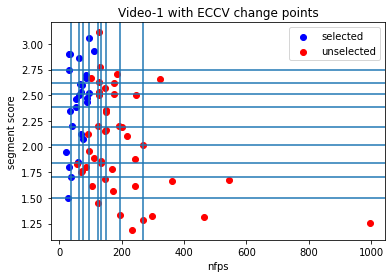

<Figure size 432x288 with 0 Axes>

In [12]:

plt.scatter(selected_e['nfps'],selected_e['seg_score'], color='blue', label='selected')
plt.scatter(unselected_e['nfps'],unselected_e['seg_score'], color='red', label='unselected')
for yi in rse:
  plt.axhline(y = yi, linestyle = '-')
for xi in rle:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with ECCV change points")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()



> Yahoo



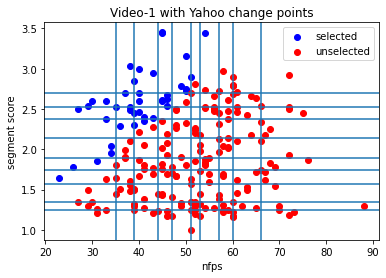

<Figure size 432x288 with 0 Axes>

In [13]:

plt.scatter(selected_y['nfps'],selected_y['seg_score'], color='blue', label='selected')
plt.scatter(unselected_y['nfps'],unselected_y['seg_score'], color='red', label='unselected')
for yi in rsy:
  plt.axhline(y = yi, linestyle = '-')
for xi in rly:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with Yahoo change points")
plt.show()
#plt.savefig("Yahoo/"+str(v)+".png")
plt.clf()



> New



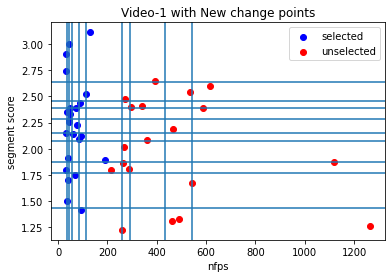

<Figure size 432x288 with 0 Axes>

In [14]:

plt.scatter(selected_j['nfps'],selected_j['seg_score'], color='blue', label='selected')
plt.scatter(unselected_j['nfps'],unselected_j['seg_score'], color='red', label='unselected')
for yi in rsj:
  plt.axhline(y = yi, linestyle = '-')
for xi in rlj:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with New change points")
plt.show()
#plt.savefig("New/"+str(v)+".png")
plt.clf()



> Uniform




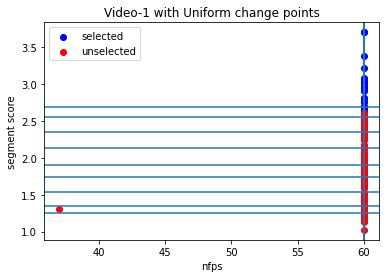

<Figure size 432x288 with 0 Axes>

In [15]:

plt.scatter(selected_u['nfps'],selected_u['seg_score'], color='blue', label='selected')
plt.scatter(unselected_u['nfps'],unselected_u['seg_score'], color='red', label='unselected')
for yi in rsu:
  plt.axhline(y = yi, linestyle = '-')
for xi in rlu:
  plt.axvline(x = xi, linestyle = '-')
plt.xlabel('nfps')
plt.ylabel('segment score')
plt.legend()
plt.title("Video-"+str(v)+" with Uniform change points")
plt.show()
#plt.savefig("Uniform/"+str(v)+".png")
plt.clf()

# New Section

In [30]:

def generate_summary2(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element
    return summary


In [31]:
def color_coding(summary):
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')
  return c

In [32]:
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]


cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]
cp_y=tvsum_cp_y['video_'+str(v)][:]
cp_j=tvsum_cp_j['video_'+str(v)][:]
cp_u=tvsum_cp_u['video_'+str(v)][:]
nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]
nfps_y=[]
nfps_j=[]
nfps_u=[]

for y in cp_y:
  nfps_y.append(y[1]-y[0]+1)
nfps_y=np.array(nfps_y)

for j in cp_j:
  nfps_j.append(j[1]-j[0]+1)
nfps_j=np.array(nfps_j)

for u in cp_u:
  nfps_u.append(u[1]-u[0]+1)
nfps_u=np.array(nfps_u)

summary_e=generate_summary2(gt, cp_e, nf, nfps_e, p)
summary_y=generate_summary2(gt, cp_y, nf, nfps_y, p)
summary_j=generate_summary2(gt, cp_j, nf, nfps_j, p)
summary_u=generate_summary2(gt, cp_u, nf, nfps_u, p)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

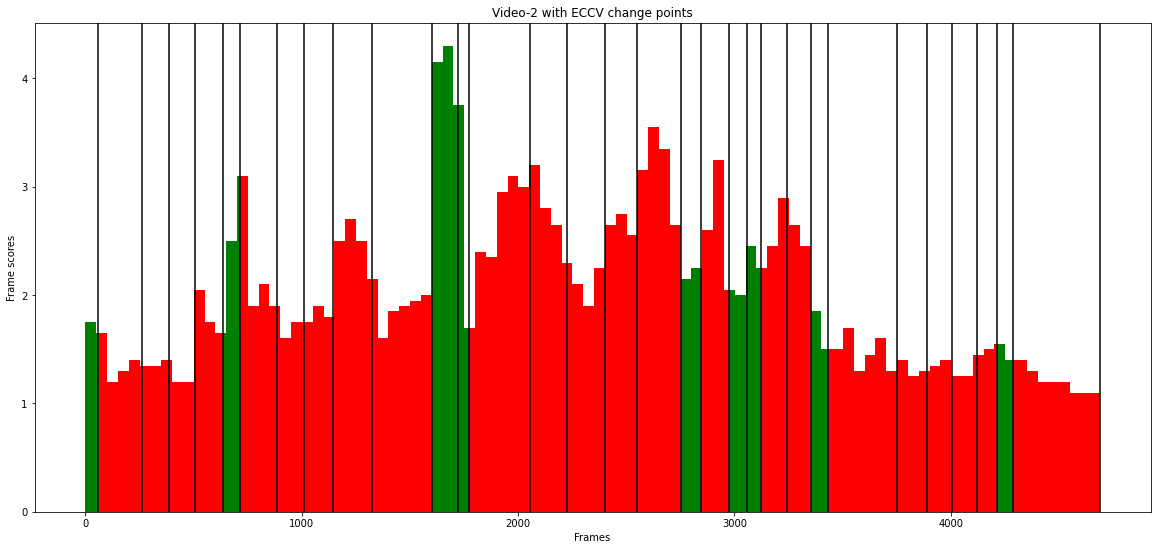

<Figure size 432x288 with 0 Axes>

In [33]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_e))
for s in cp_e:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with ECCV change points")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()



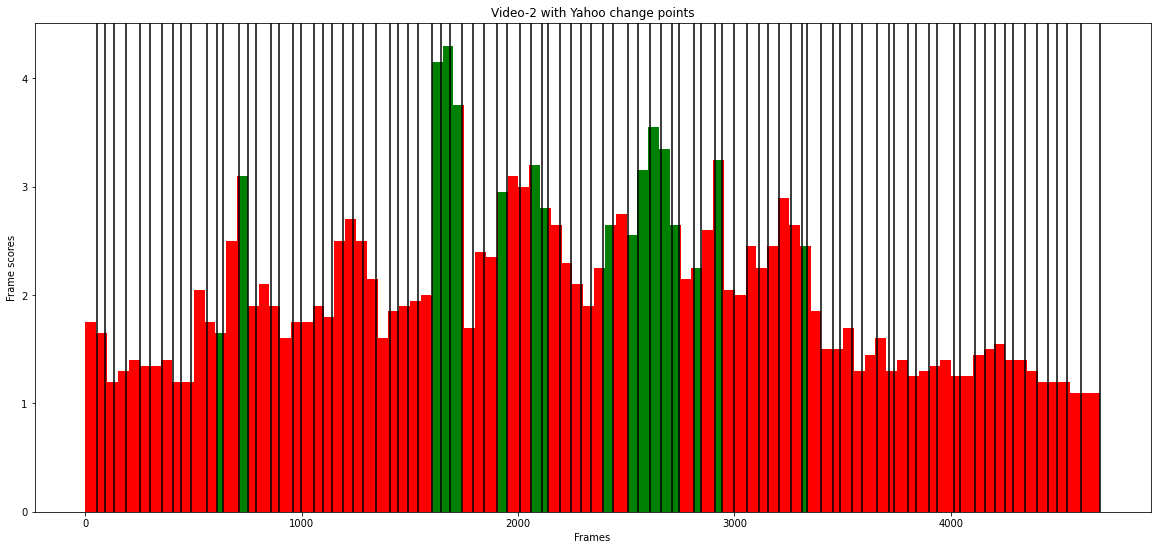

<Figure size 432x288 with 0 Axes>

In [34]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_y))
for s in cp_y:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with Yahoo change points")
plt.show()
#plt.savefig("Yahoo/"+str(v)+".png")
plt.clf()


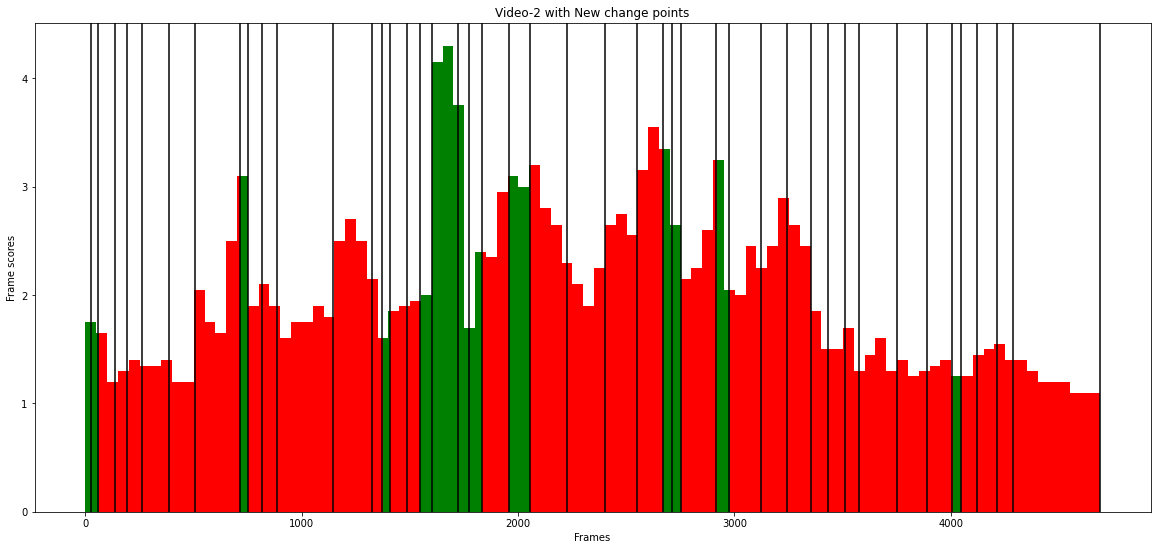

<Figure size 432x288 with 0 Axes>

In [35]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_j))
for s in cp_j:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with New change points")
plt.show()
#plt.savefig("New/"+str(v)+".png")
plt.clf()


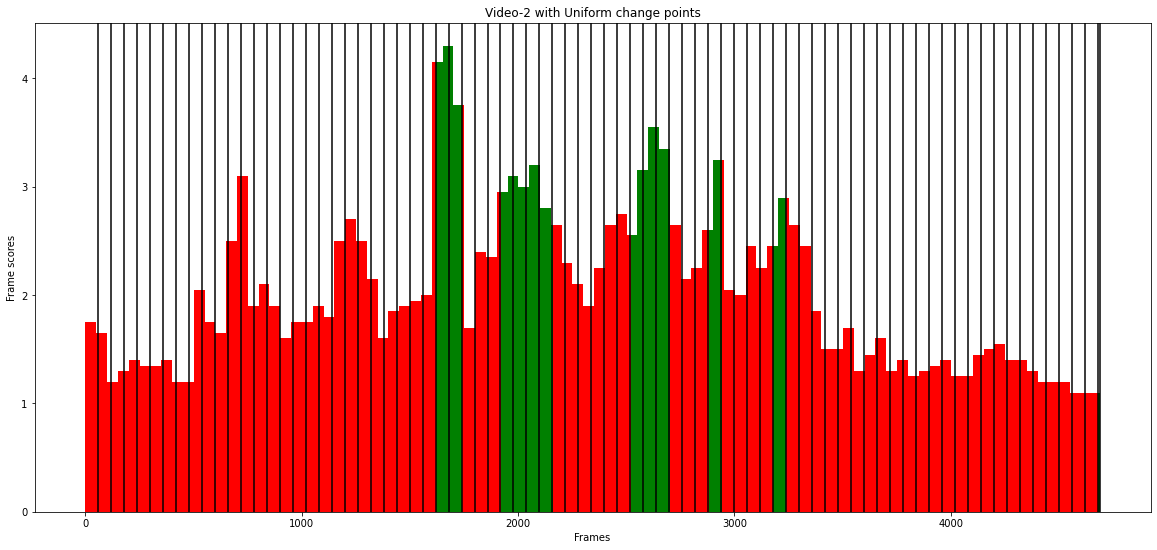

<Figure size 432x288 with 0 Axes>

In [36]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=gt, width=1, color=color_coding(summary_u))
for s in cp_u:
  plt.axvline(x=s[1], color='black')
plt.xlabel("Frames")
plt.ylabel("Frame scores")
plt.title("Video-"+str(v)+" with Uniform change points")
plt.show()
#plt.savefig("Uniform/"+str(v)+".png")
plt.clf()

# KC-3

In [40]:
def generate_summary3(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    frame_seg_score=[]
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        frame_seg_score.extend([seg_score[seg_idx] for i in range(nf)])
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element

    return frame_seg_score, summary


In [39]:

def color_coding(summary):
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')
  return c


In [41]:
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]

cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]
cp_y=tvsum_cp_y['video_'+str(v)][:]
cp_j=tvsum_cp_j['video_'+str(v)][:]
cp_u=tvsum_cp_u['video_'+str(v)][:]
nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]
nfps_y=[]
nfps_j=[]
nfps_u=[]

for y in cp_y:
  nfps_y.append(y[1]-y[0]+1)
nfps_y=np.array(nfps_y)

for j in cp_j:
  nfps_j.append(j[1]-j[0]+1)
nfps_j=np.array(nfps_j)

for u in cp_u:
  nfps_u.append(u[1]-u[0]+1)
nfps_u=np.array(nfps_u)

frame_seg_score_e, summary_e=generate_summary3(gt, cp_e, nf, nfps_e, p)
frame_seg_score_y, summary_y=generate_summary3(gt, cp_y, nf, nfps_y, p)
frame_seg_score_j, summary_j=generate_summary3(gt, cp_j, nf, nfps_j, p)
frame_seg_score_u, summary_u=generate_summary3(gt, cp_u, nf, nfps_u, p)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

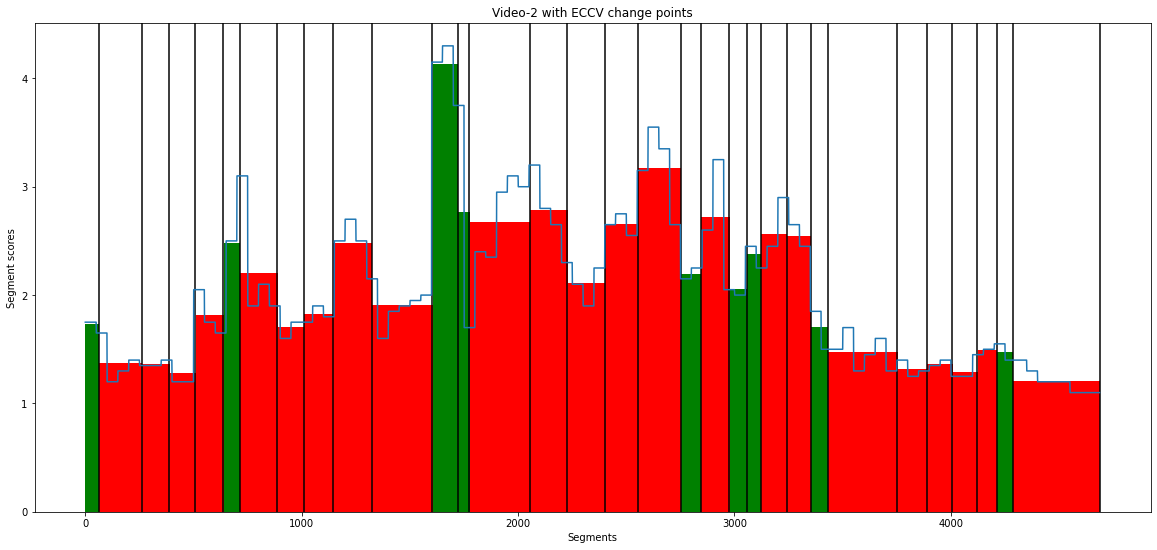

<Figure size 432x288 with 0 Axes>

In [42]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_e, width=1, color=color_coding(summary_e))
for s in cp_e:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with ECCV change points")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()


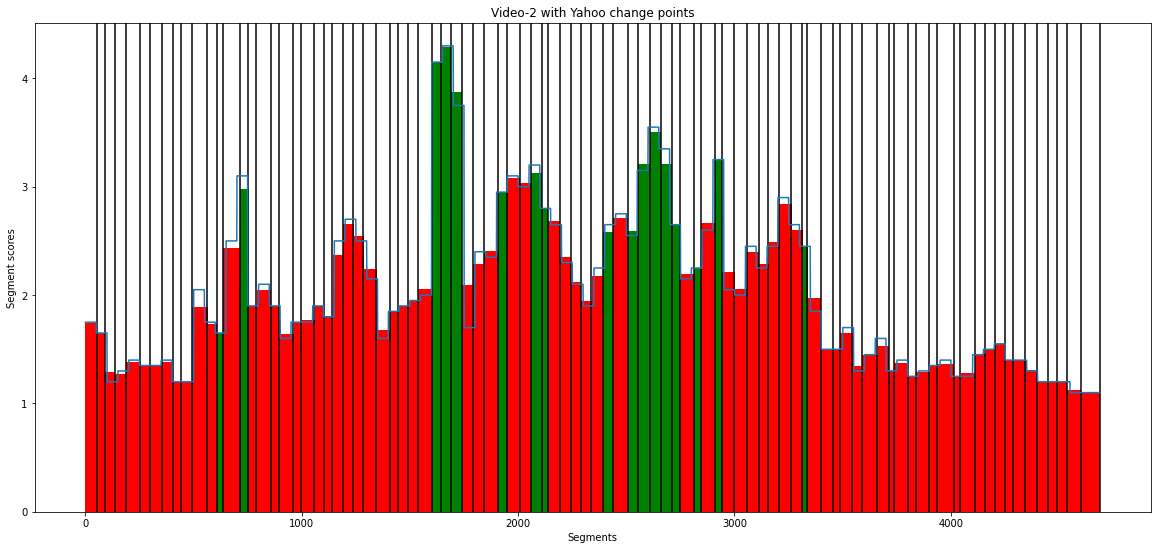

<Figure size 432x288 with 0 Axes>

In [43]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_y, width=1, color=color_coding(summary_y))
for s in cp_y:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with Yahoo change points")
plt.show()
#plt.savefig("Yahoo/"+str(v)+".png")
plt.clf()


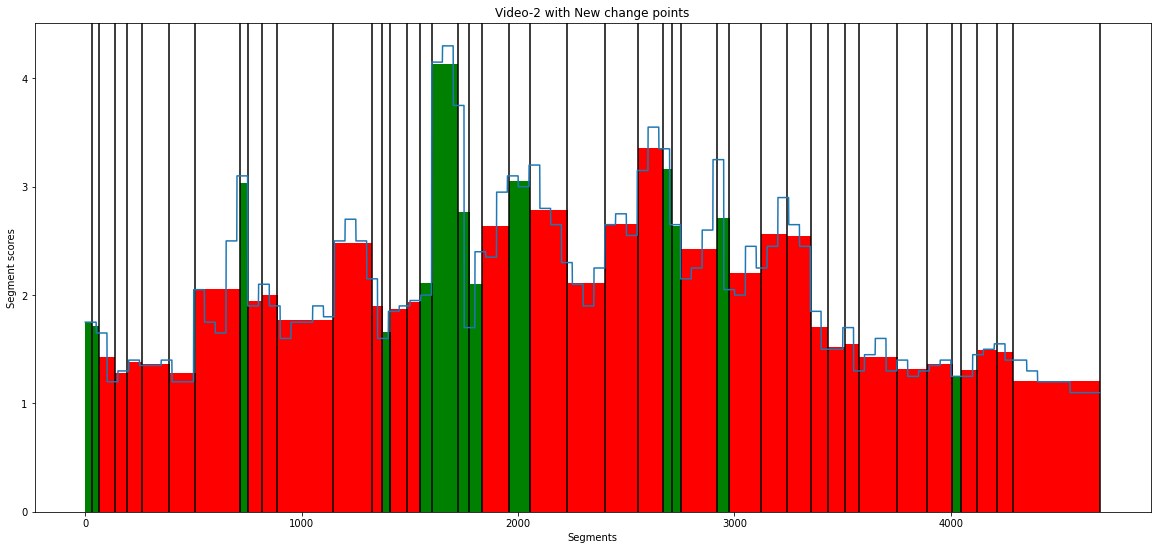

<Figure size 432x288 with 0 Axes>

In [44]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_j, width=1, color=color_coding(summary_j))
for s in cp_j:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with New change points")
plt.show()
#plt.savefig("New/"+str(v)+".png")
plt.clf()


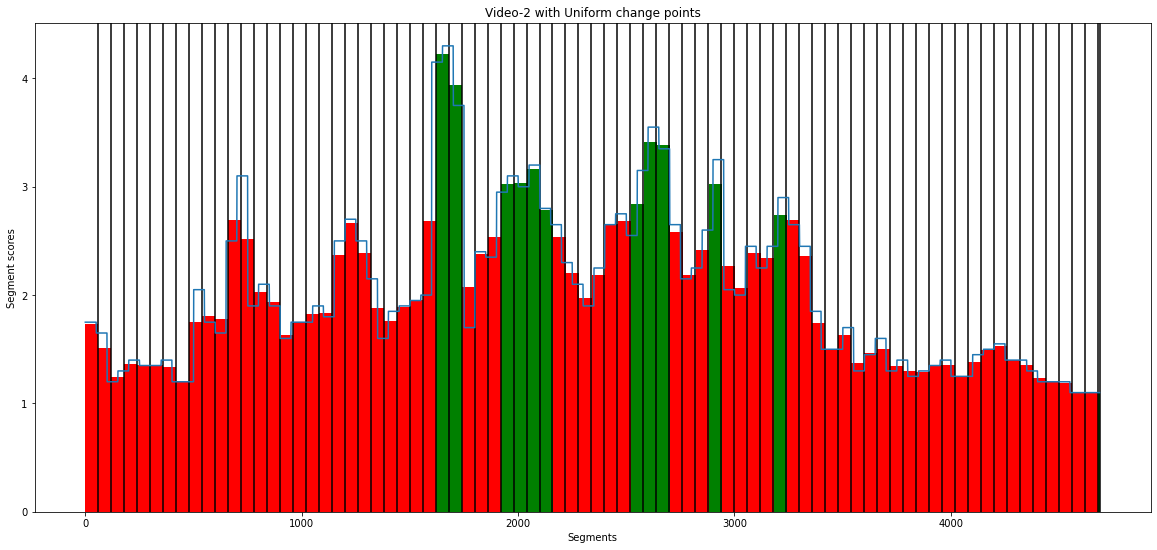

<Figure size 432x288 with 0 Axes>

In [45]:

fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_u, width=1, color=color_coding(summary_u))
for s in cp_u:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with Uniform change points")
plt.show()
#plt.savefig("Uniform/"+str(v)+".png")
plt.clf()